In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave

import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import img_to_array, load_img

import cv2
import PIL

%load_ext tensorboard
import datetime
import time

In [2]:
train_dir = "images/"

#Resize images
img_width = 256
img_height = 256
image_size = (img_width, img_height)

train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True)
        
train = train_datagen.flow_from_directory(batch_size=128,
                                                     directory=train_dir,
                                                     target_size=image_size,
                                                     class_mode=None)

#Convert from RGB to LAB
X = []
y = []
for img in train[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0])
        y.append(lab[:,:,1:] / 128)
    except:
        print('error')
        
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y

Found 10000 images belonging to 1 classes.


C:\Users\micha\miniconda3\envs\tensorflow-gpu\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


In [3]:
# Load and preprocessing the test images
test_dir = 'photos'

test_datagen = ImageDataGenerator(
        rescale=1./255,
        )

test = test_datagen.flow_from_directory(batch_size=128,
                                                     directory=test_dir,
                                                     target_size=image_size,
                                                     class_mode=None)

Found 513 images belonging to 1 classes.


In [6]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model1-relu-adam-mse.h5", save_best_only=True)
early_stop = EarlyStopping(patience=10)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop, tensorboard_callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 512)      

4/4 [==============================] - 0s 150ms/step
0.6602606773376465


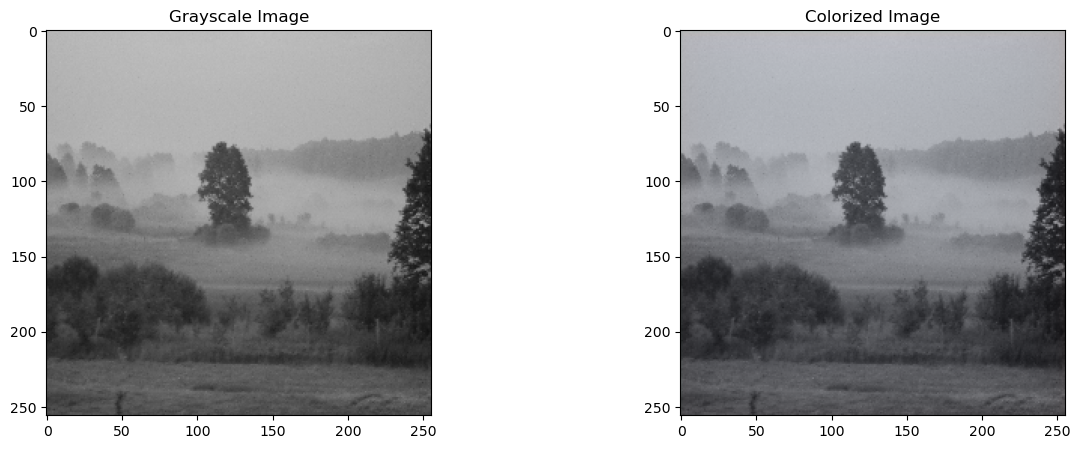

In [25]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

In [26]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model2-relu-adam-mse.h5", save_best_only=True)
early_stop = EarlyStopping(patience=10)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 conv2d_40 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 256)       295168    
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 256)      

4/4 [==============================] - 1s 146ms/step
0.6976253986358643


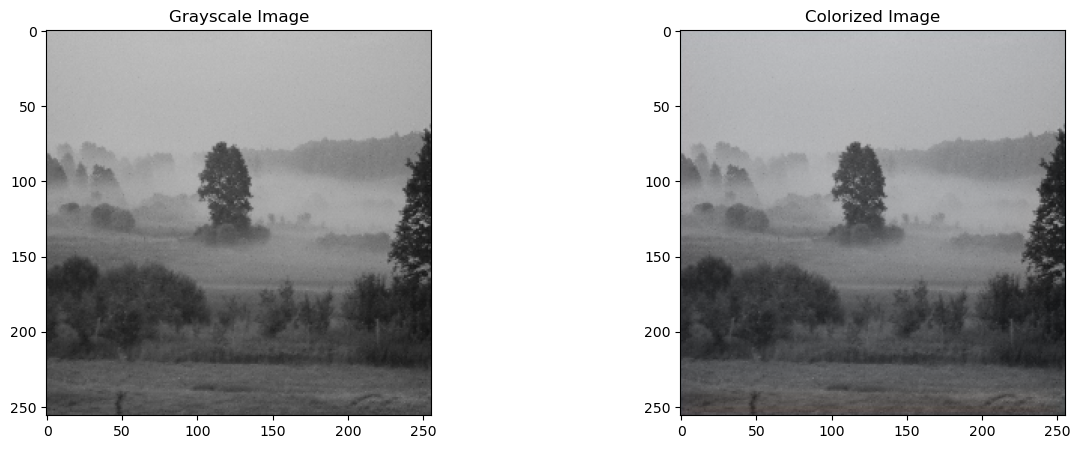

In [27]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

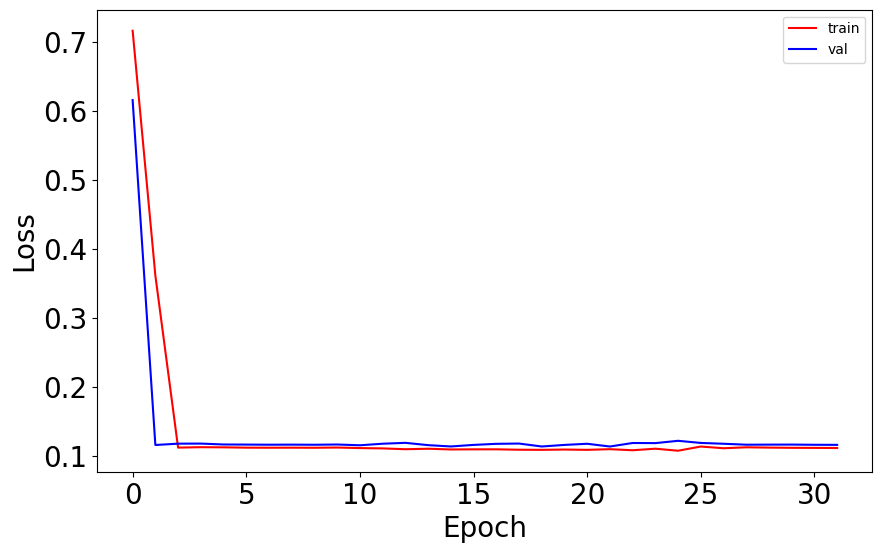

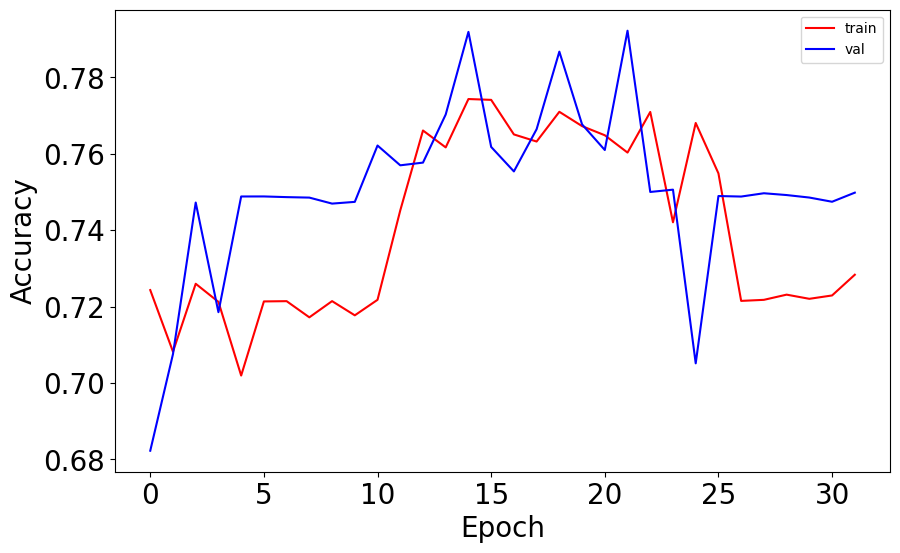

In [28]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [29]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-adam-mse.h5", save_best_only=True)
early_stop = EarlyStopping(patience=20)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 conv2d_52 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_53 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 conv2d_54 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_55 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_56 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 64)       

4/4 [==============================] - 0s 110ms/step
0.6189010143280029


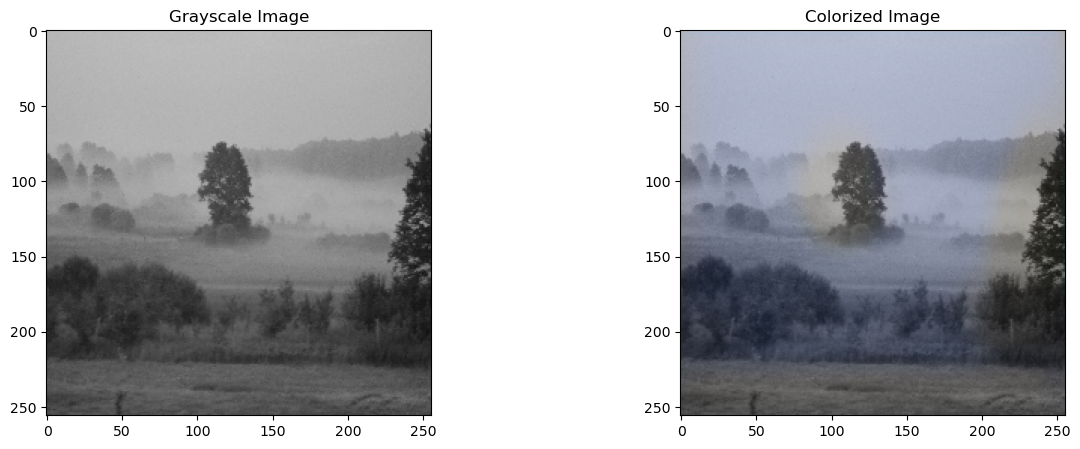

In [30]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

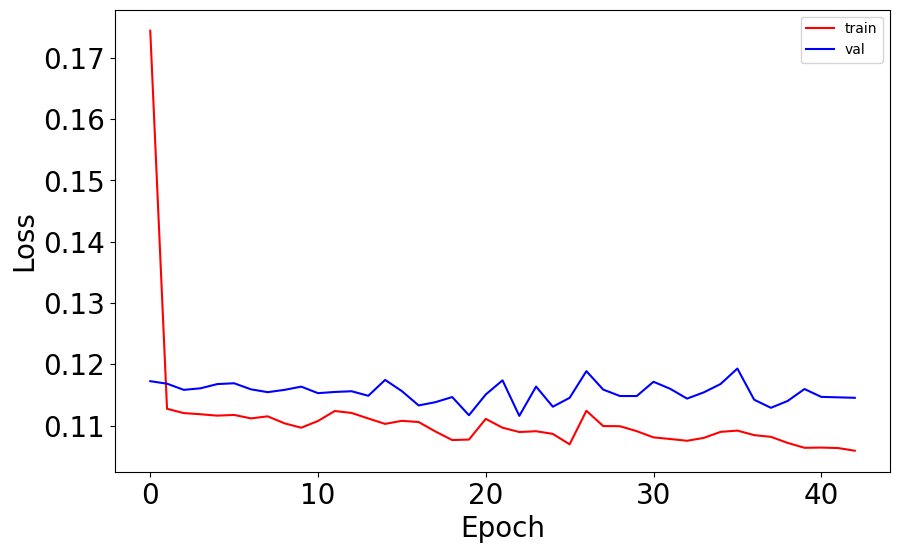

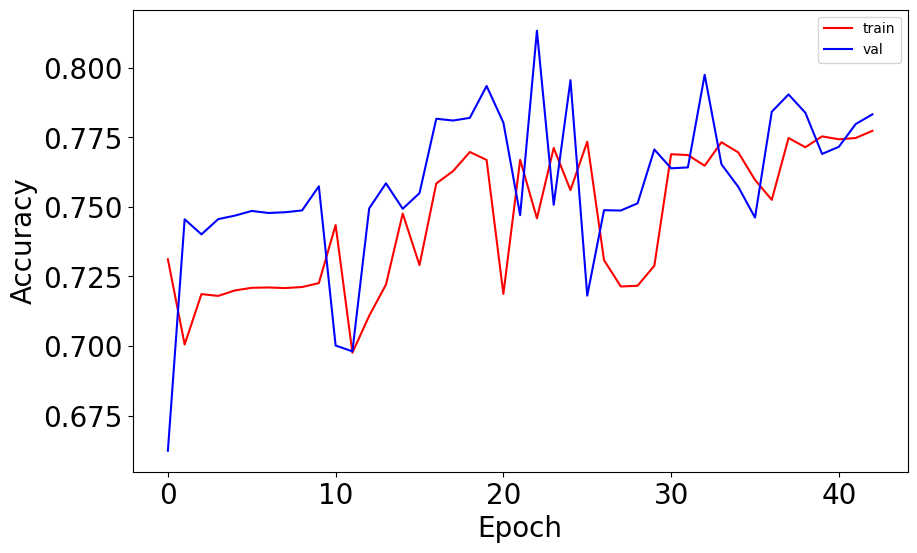

In [31]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [32]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='tanh', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(16, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(64, (3, 3), activation='tanh', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(128, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(256, (3, 3), activation='tanh', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='tanh', padding='same'))
model.add(Conv2D(16, (3,3), activation='tanh', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-tanh-adam-mse.h5", save_best_only=True)
early_stop = EarlyStopping(patience=20)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 conv2d_66 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_67 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 conv2d_68 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 64)       

4/4 [==============================] - 1s 136ms/step
0.6955981254577637


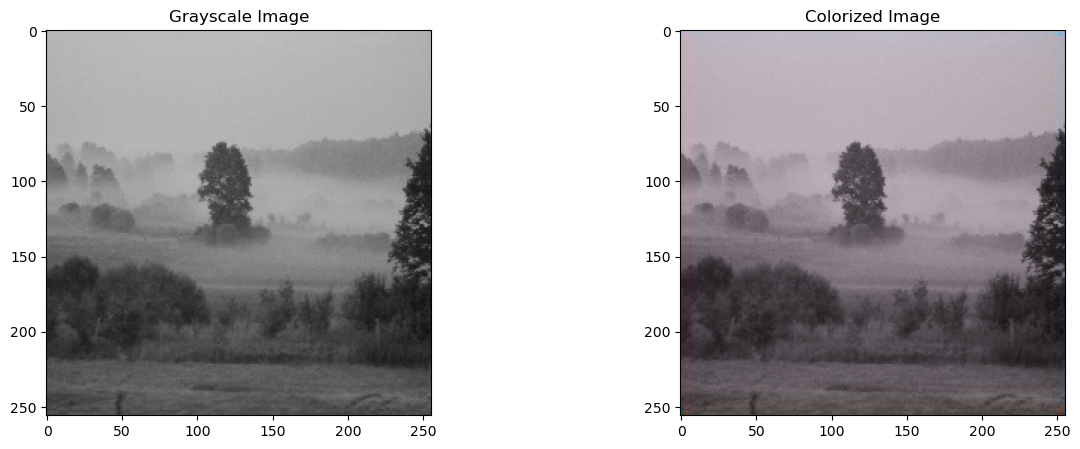

In [33]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

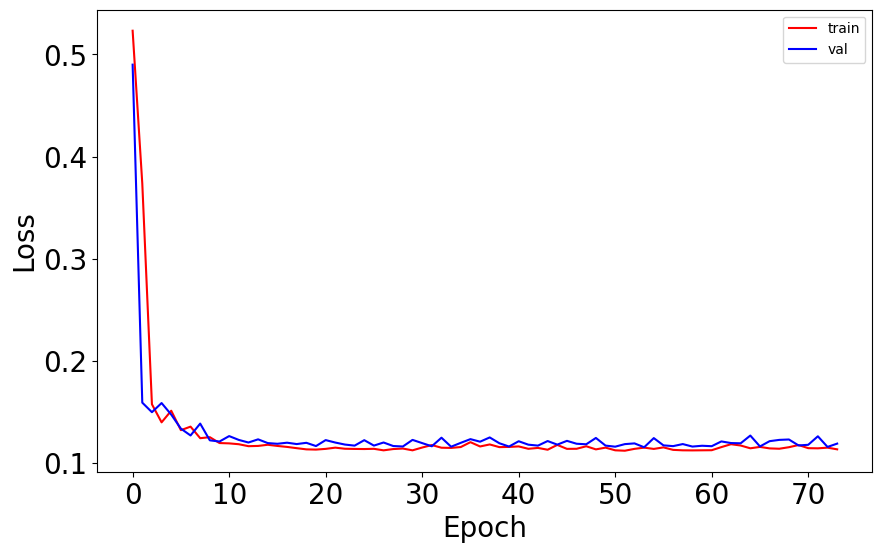

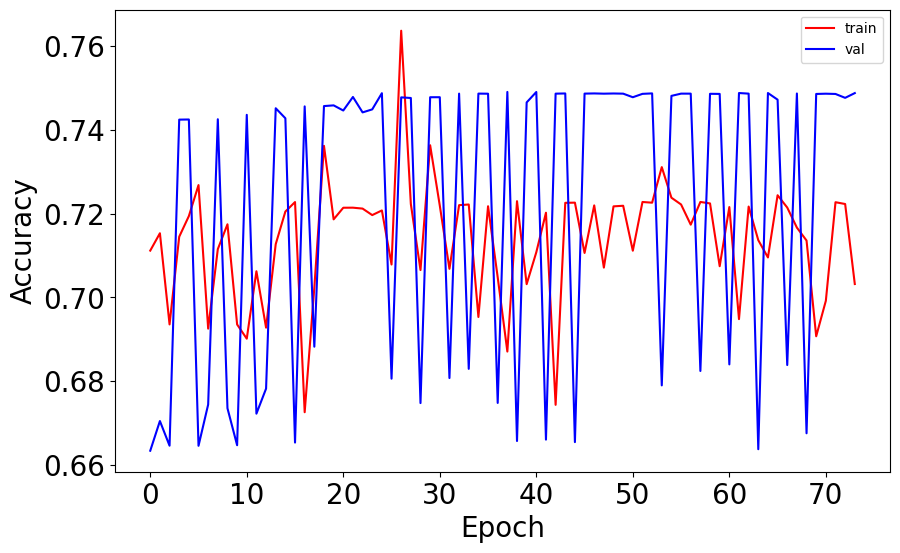

In [34]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [35]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='sigmoid', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='sigmoid', padding='same'))
model.add(Conv2D(16, (3, 3), activation='sigmoid', padding='same'))
model.add(Conv2D(32, (3, 3), activation='sigmoid', padding='same'))
model.add(Conv2D(64, (3, 3), activation='sigmoid', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='sigmoid', padding='same'))
model.add(Conv2D(64, (3, 3), activation='sigmoid', padding='same'))
model.add(Conv2D(128, (3, 3), activation='sigmoid', padding='same'))
model.add(Conv2D(256, (3, 3), activation='sigmoid', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='sigmoid', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='sigmoid', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='sigmoid', padding='same'))
model.add(Conv2D(16, (3,3), activation='sigmoid', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-sigmoid-adam-mse.h5", save_best_only=True)
early_stop = EarlyStopping(patience=20)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 conv2d_80 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_81 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 conv2d_82 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_84 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_85 (Conv2D)          (None, 64, 64, 64)       

4/4 [==============================] - 1s 141ms/step
0.7096052169799805


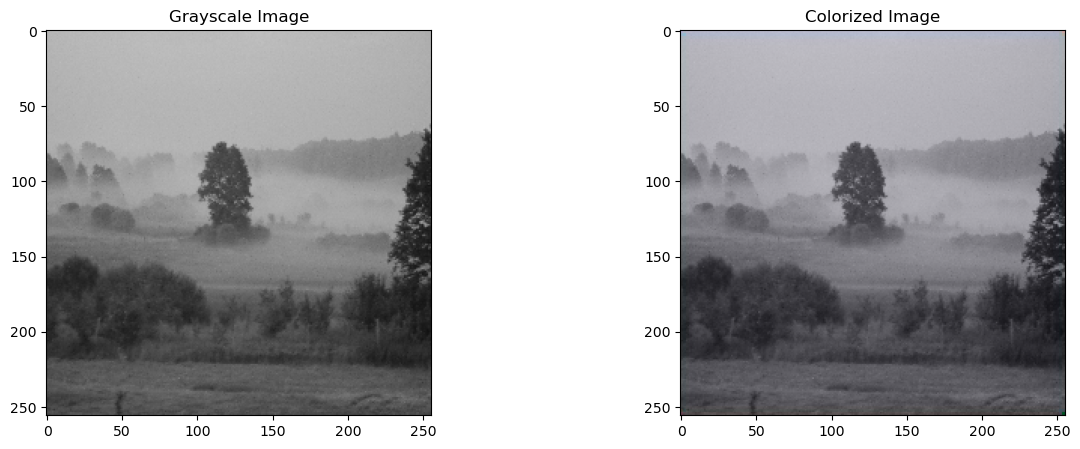

In [36]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

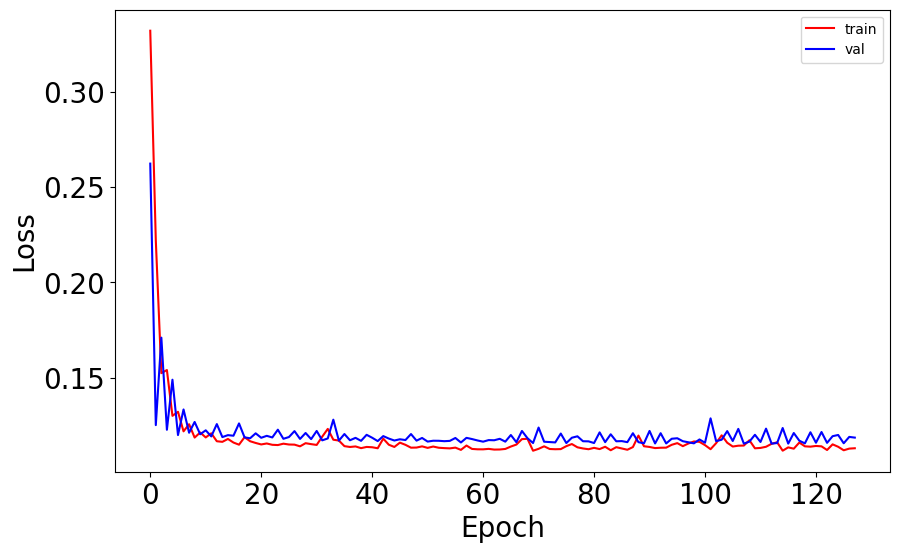

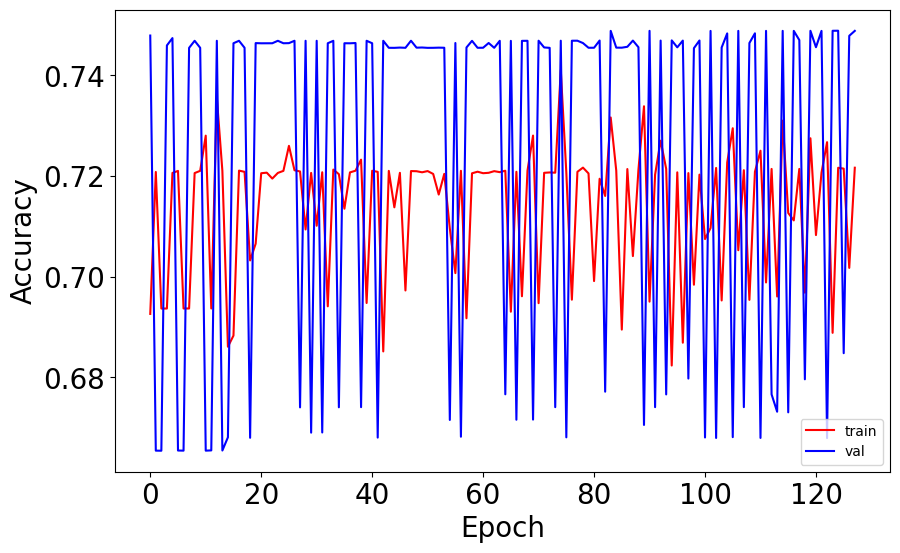

In [37]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [38]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='softmax', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='softmax', padding='same'))
model.add(Conv2D(16, (3, 3), activation='softmax', padding='same'))
model.add(Conv2D(32, (3, 3), activation='softmax', padding='same'))
model.add(Conv2D(64, (3, 3), activation='softmax', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='softmax', padding='same'))
model.add(Conv2D(64, (3, 3), activation='softmax', padding='same'))
model.add(Conv2D(128, (3, 3), activation='softmax', padding='same'))
model.add(Conv2D(256, (3, 3), activation='softmax', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='softmax', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='softmax', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='softmax', padding='same'))
model.add(Conv2D(16, (3,3), activation='softmax', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-softmax-adam-mse.h5", save_best_only=True)
early_stop = EarlyStopping(patience=20)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 conv2d_94 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_95 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 conv2d_96 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_97 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_98 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_99 (Conv2D)          (None, 64, 64, 64)       

4/4 [==============================] - 1s 177ms/step
0.8107588291168213


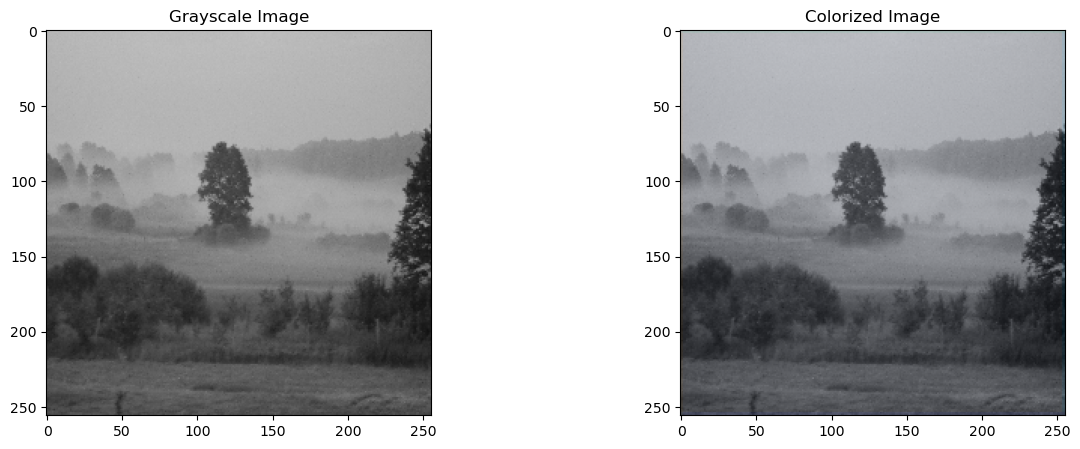

In [39]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

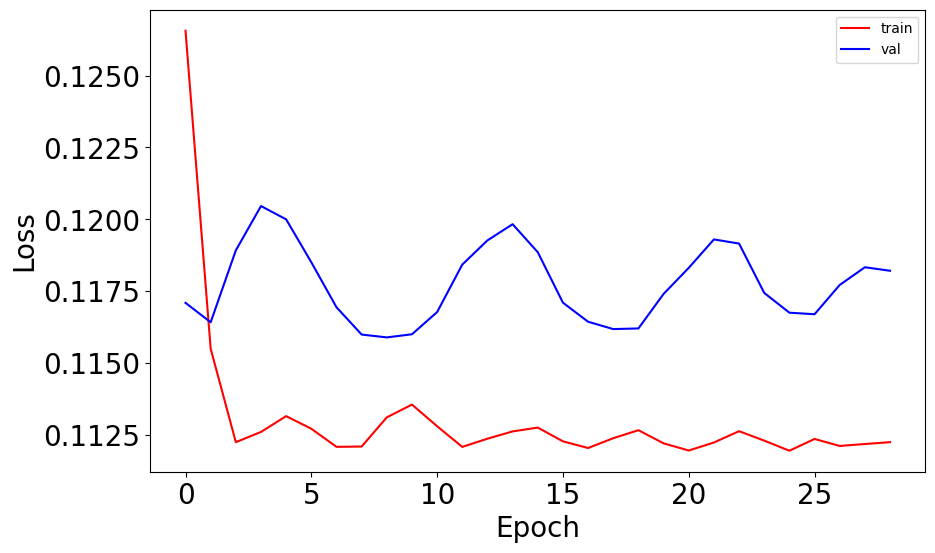

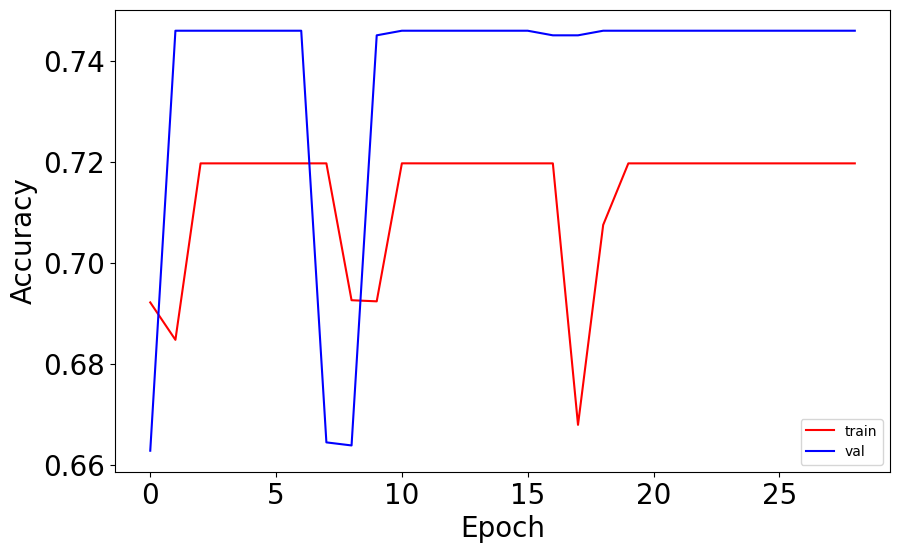

In [40]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [41]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss='mse' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-mse.h5", save_best_only=True)
early_stop = EarlyStopping(patience=20)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_108 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_109 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_110 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_111 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_112 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_113 (Conv2D)         (None, 64, 64, 64)       

4/4 [==============================] - 1s 140ms/step
0.6964499950408936


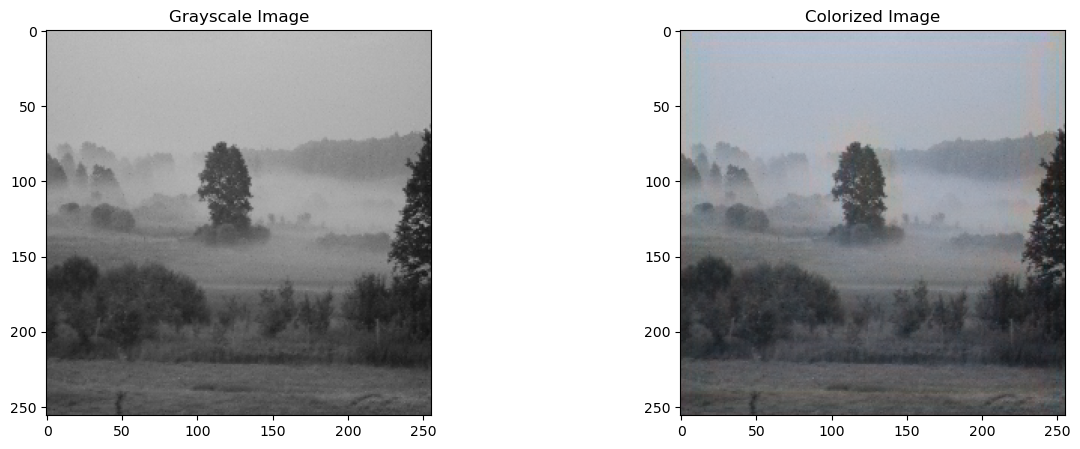

In [42]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

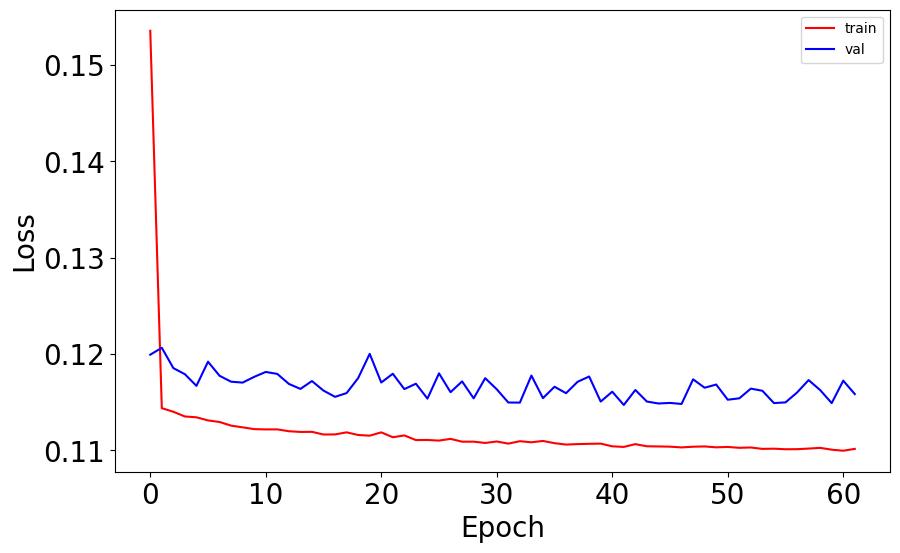

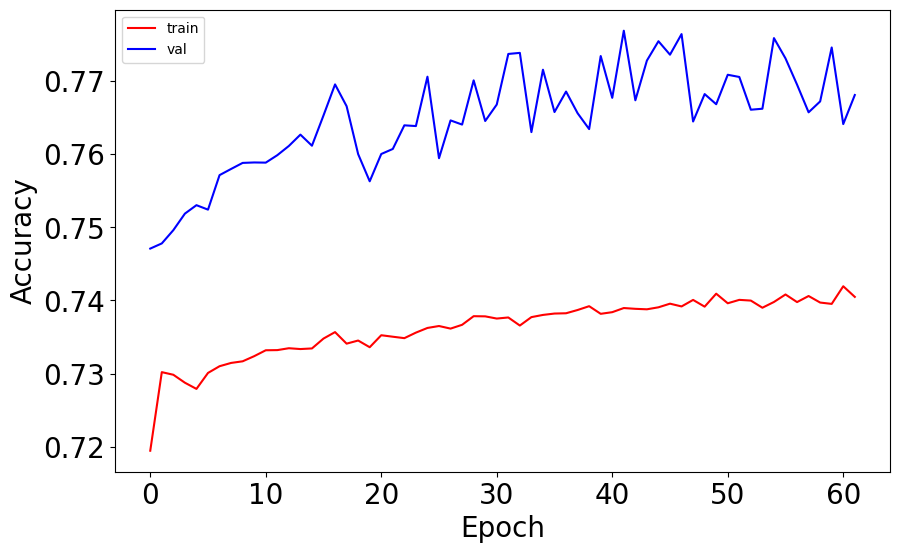

In [43]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [44]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-rmsprop-mse.h5", save_best_only=True)
early_stop = EarlyStopping(patience=20)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_122 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_123 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_124 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_125 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_126 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_127 (Conv2D)         (None, 64, 64, 64)       

4/4 [==============================] - 0s 110ms/step
0.5999062061309814


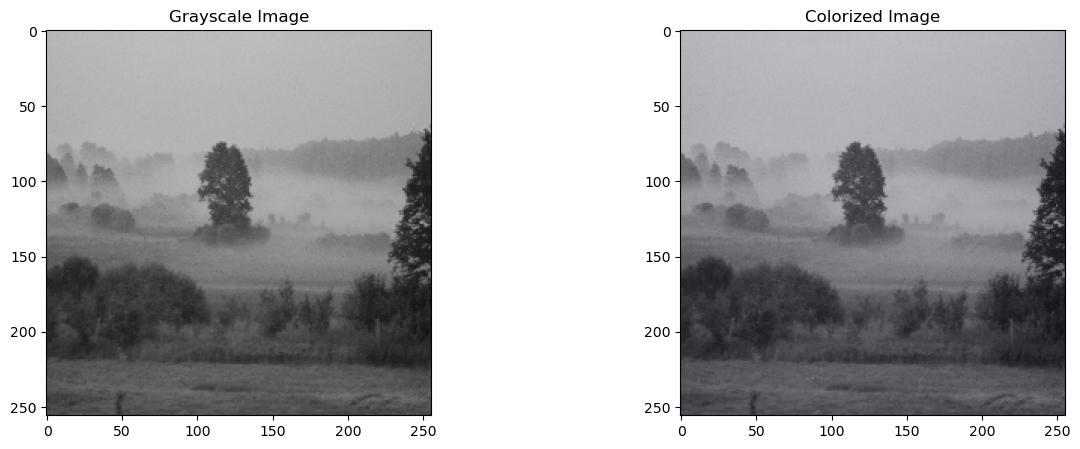

In [45]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

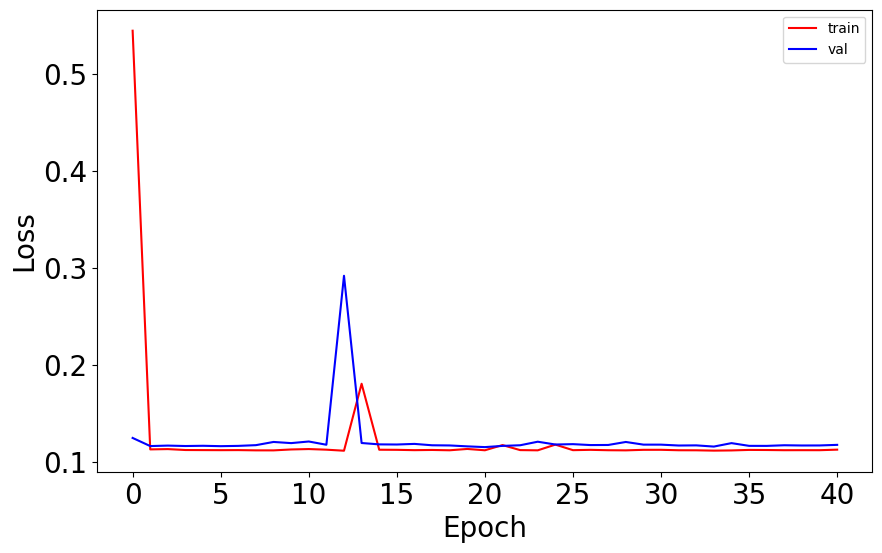

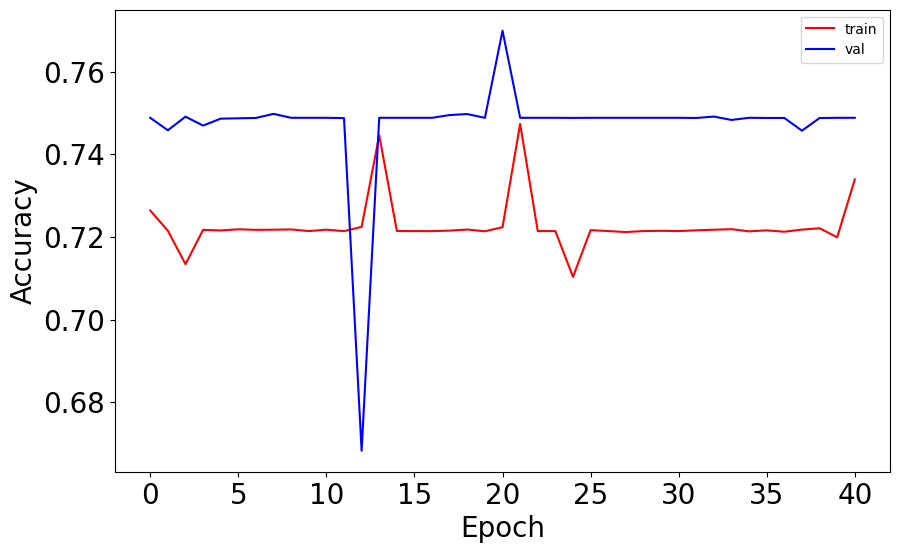

In [46]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [47]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss='cosine_similarity' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-cs.h5", save_best_only=True)
early_stop = EarlyStopping(patience=50)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_136 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_137 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_138 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_139 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_140 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_141 (Conv2D)         (None, 64, 64, 64)      

4/4 [==============================] - 1s 135ms/step
0.6603913307189941


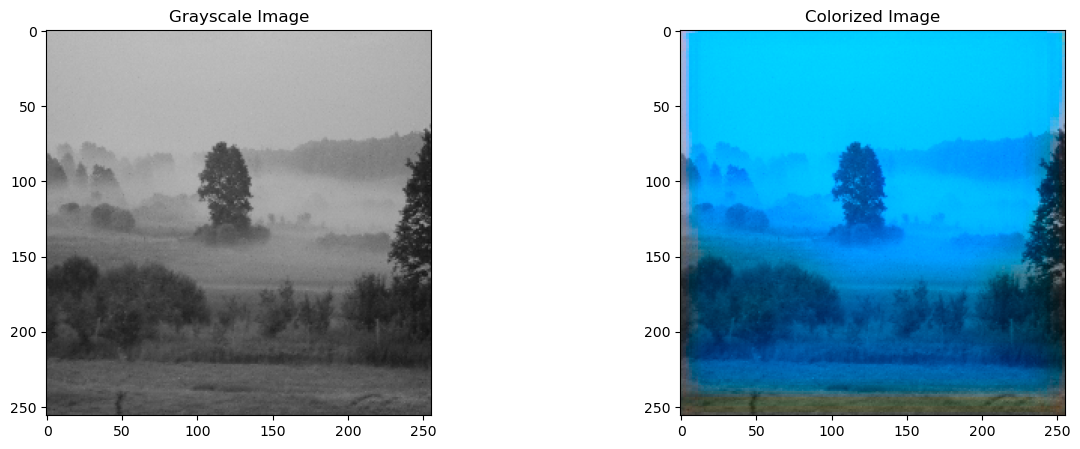

In [48]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

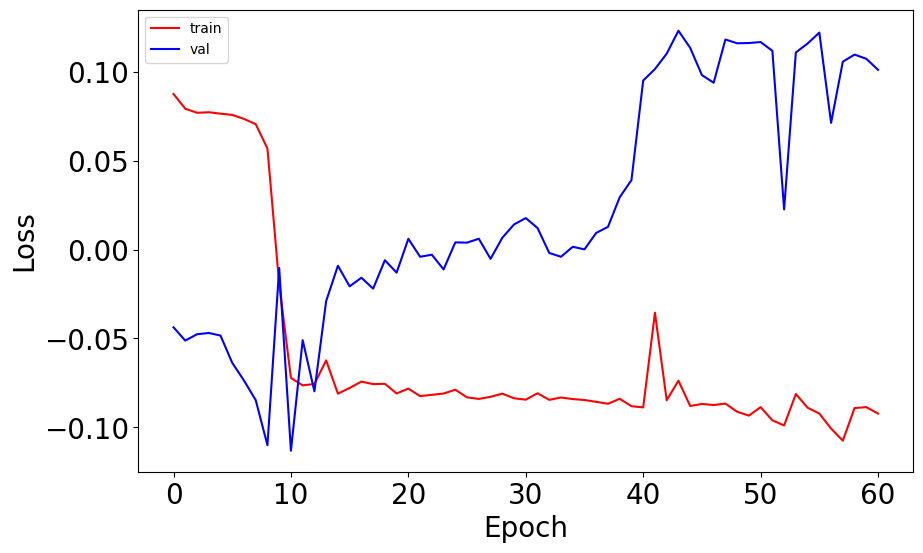

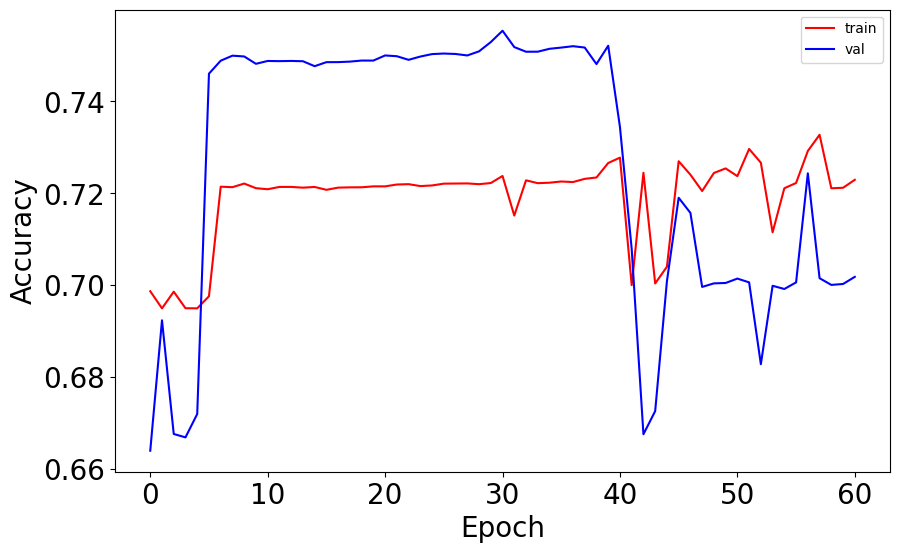

In [49]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history.history['loss'], 'r', label='train')
ax.plot(history.history['val_loss'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [50]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss='mae' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-mae-v2.h5", save_best_only=True)
early_stop = EarlyStopping(patience=20)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_149 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_150 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_151 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_152 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_153 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_154 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_155 (Conv2D)         (None, 64, 64, 64)      

4/4 [==============================] - 1s 139ms/step
0.7026042938232422


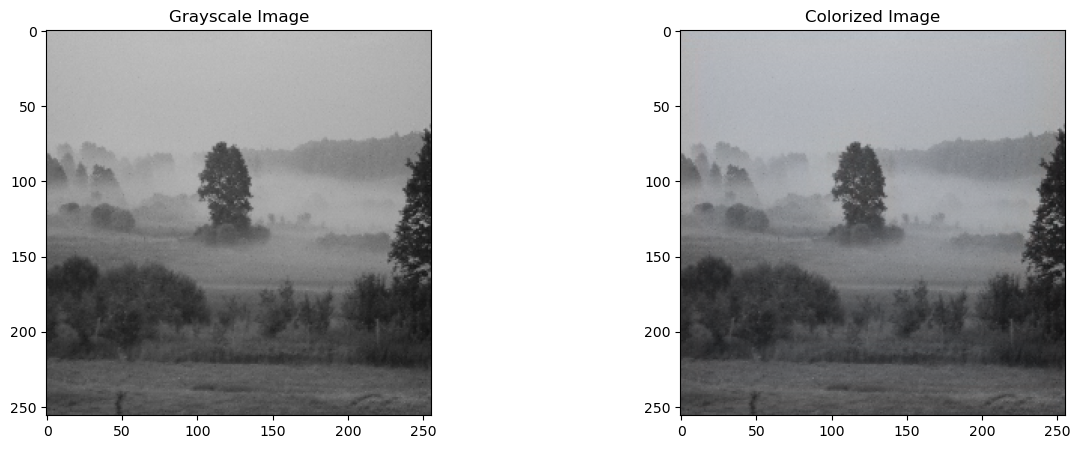

In [51]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

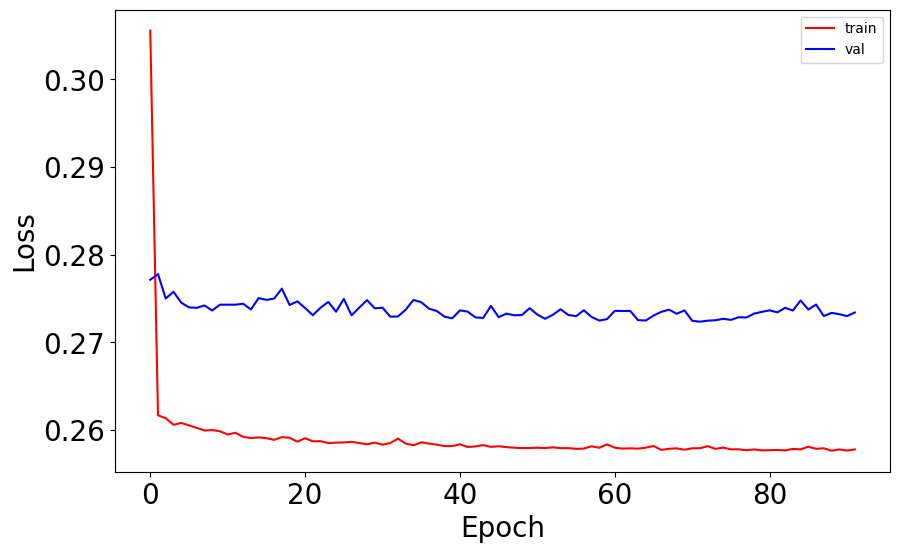

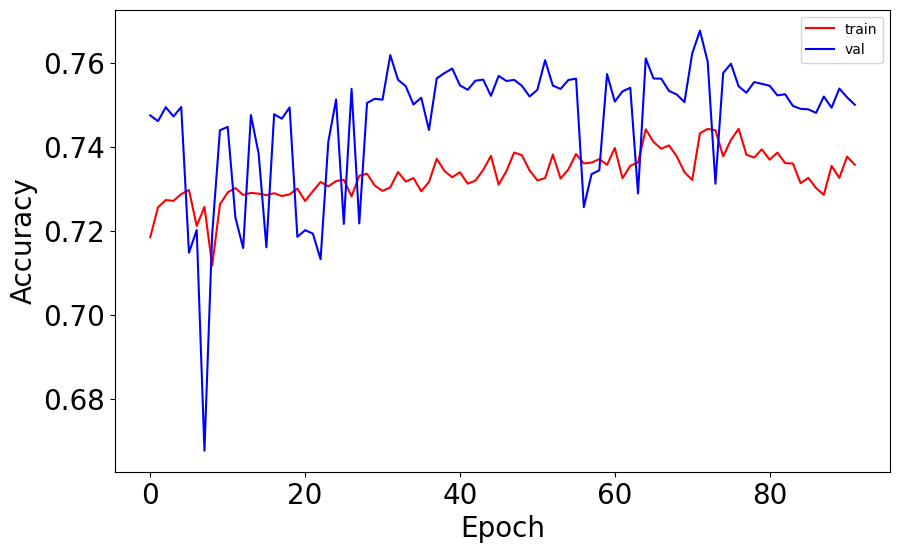

In [52]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [53]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss=tf.keras.losses.CosineSimilarity(axis=1), metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-cs-final.h5", save_best_only=True)
early_stop = EarlyStopping(patience=20)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[tensorboard_callback])
model.save('model3-relu-sgd-cs-final.h5')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_163 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_164 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_165 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_166 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_167 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_168 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_169 (Conv2D)         (None, 64, 64, 64)      

4/4 [==============================] - 1s 167ms/step
0.7576510906219482


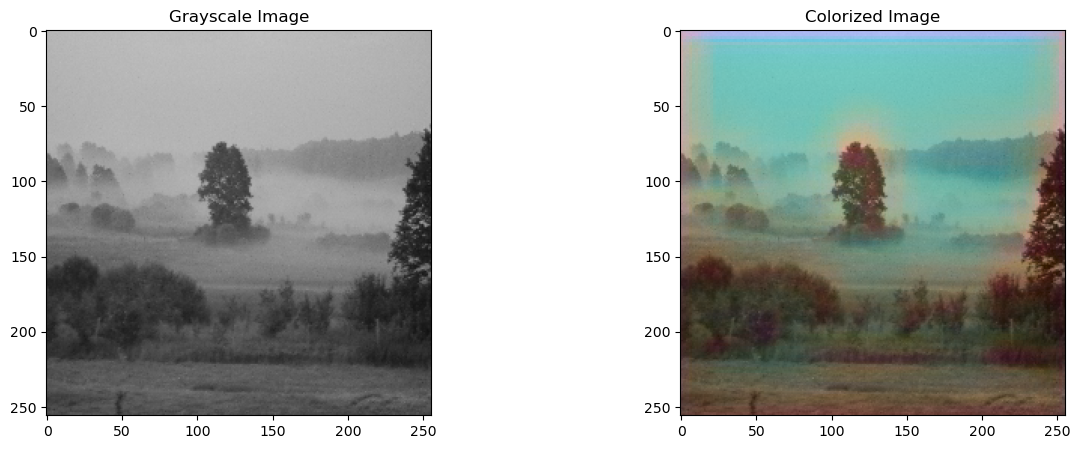

In [54]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

CROSS-VALIDATION

In [55]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss=tf.keras.losses.CosineSimilarity(axis=1), metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-cs-cross1.h5", save_best_only=True)
early_stop = EarlyStopping(patience=50)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_177 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_178 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_179 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_180 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_181 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_182 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_183 (Conv2D)         (None, 64, 64, 64)      

In [56]:
X_new = np.roll(X, 2000)
y_new = np.roll(y, 2000)

In [57]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss=tf.keras.losses.CosineSimilarity(axis=1), metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-cs-cross2.h5", save_best_only=True)
early_stop = EarlyStopping(patience=50)

history = model.fit(x=X_new,y=y_new,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_191 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_192 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_193 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_194 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_195 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_196 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_197 (Conv2D)         (None, 64, 64, 64)      

In [58]:
X_new2 = np.roll(X, 4000)
y_new2 = np.roll(y, 4000)

In [59]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss=tf.keras.losses.CosineSimilarity(axis=1), metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-cs-cross3.h5", save_best_only=True)
early_stop = EarlyStopping(patience=50)

history = model.fit(x=X_new2,y=y_new2,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_205 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_206 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_207 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_208 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_209 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_210 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_211 (Conv2D)         (None, 64, 64, 64)      

In [60]:
X_new3 = np.roll(X, 6000)
y_new3 = np.roll(y, 6000)

In [61]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss=tf.keras.losses.CosineSimilarity(axis=1), metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-cs-cross4.h5", save_best_only=True)
early_stop = EarlyStopping(patience=50)

history = model.fit(x=X_new3,y=y_new3,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_219 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_220 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_221 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_222 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_223 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_224 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_225 (Conv2D)         (None, 64, 64, 64)      

In [62]:
X_new4 = np.roll(X, 8000)
y_new4 = np.roll(y, 8000)

In [63]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss=tf.keras.losses.CosineSimilarity(axis=1), metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-cs-cross5.h5", save_best_only=True)
early_stop = EarlyStopping(patience=50)

history = model.fit(x=X_new4,y=y_new4,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_233 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_234 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_235 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_236 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_237 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_238 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_239 (Conv2D)         (None, 64, 64, 64)      

LOADING CROSS-VALIDATION MODELS

4/4 [==============================] - 1s 134ms/step
0.6645963191986084


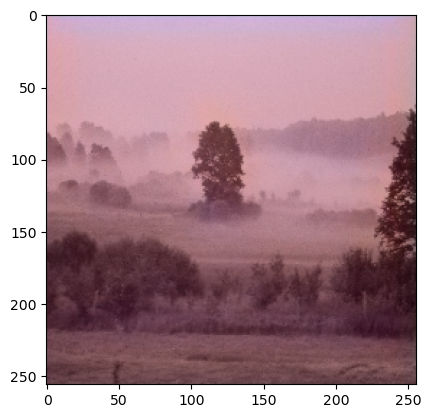

In [64]:
# Load saved model
models = tf.keras.models.load_model(
    'model3-relu-sgd-cs-cross1.h5',
    custom_objects=None,
    compile=True)

#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = models.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img1 = lab2rgb(result)
plt.imshow(color_img1)
plt.show()

4/4 [==============================] - 0s 124ms/step
0.6461014747619629


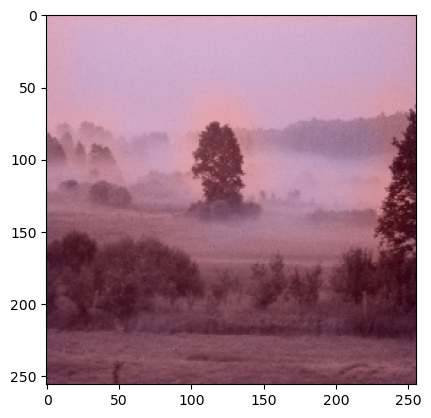

In [65]:
# Load saved model
models = tf.keras.models.load_model(
    'model3-relu-sgd-cs-cross2.h5',
    custom_objects=None,
    compile=True)

#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = models.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img2 = lab2rgb(result)
plt.imshow(color_img2)
plt.show()

4/4 [==============================] - 1s 132ms/step
0.6551046371459961


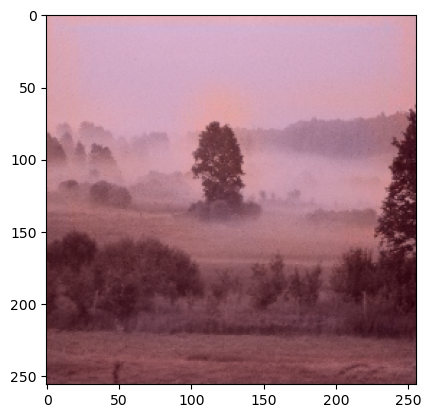

In [66]:
# Load saved model
models = tf.keras.models.load_model(
    'model3-relu-sgd-cs-cross3.h5',
    custom_objects=None,
    compile=True)

#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = models.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img3 = lab2rgb(result)
plt.imshow(color_img3)
plt.show()

4/4 [==============================] - 0s 101ms/step
0.55605149269104


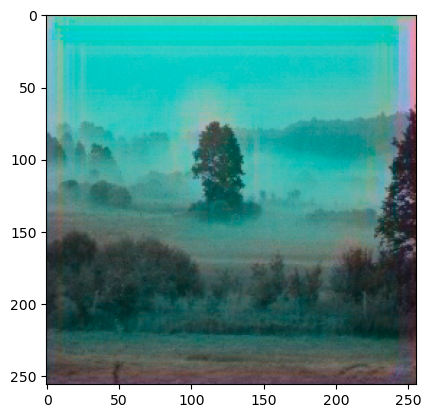

In [67]:
# Load saved model
models = tf.keras.models.load_model(
    'model3-relu-sgd-cs-cross4.h5',
    custom_objects=None,
    compile=True)

#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = models.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img4 = lab2rgb(result)
plt.imshow(color_img4)
plt.show()

4/4 [==============================] - 0s 116ms/step
0.6206865310668945


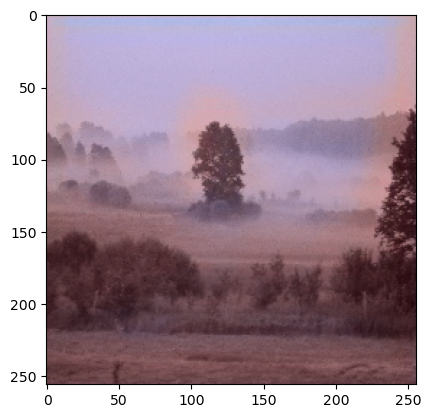

In [68]:
# Load saved model
models = tf.keras.models.load_model(
    'model3-relu-sgd-cs-cross5.h5',
    custom_objects=None,
    compile=True)

#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = models.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img5 = lab2rgb(result)
plt.imshow(color_img5)
plt.show()

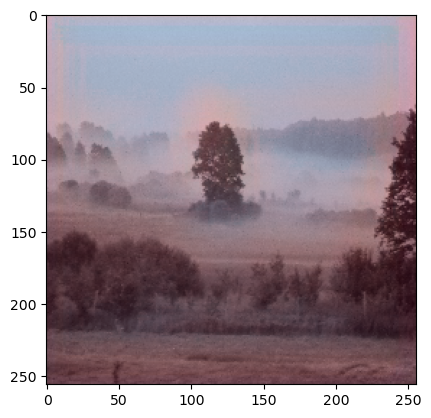

In [69]:
color_img6 = (color_img1 + color_img2 + color_img3 + color_img4 + color_img5)/5
plt.imshow(color_img6)
plt.show()

OVERFITTNG

In [70]:
train_dir = "overfitting/"

#Resize images
img_width = 256
img_height = 256
image_size = (img_width, img_height)

train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True)
        
train = train_datagen.flow_from_directory(batch_size=128,
                                                     directory=train_dir,
                                                     target_size=image_size,
                                                     class_mode=None)

#Convert from RGB to LAB
X = []
y = []
for img in train[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0])
        y.append(lab[:,:,1:] / 128)
    except:
        print('error')
        
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y

Found 10000 images belonging to 1 classes.


In [71]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))


#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss='cosine_similarity' , metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model3-relu-sgd-cs-overfitting.h5", save_best_only=True)
early_stop = EarlyStopping(patience=50)

history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[checkpoint, early_stop])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_247 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_248 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_249 (Conv2D)         (None, 128, 128, 16)      4624      
                                                                 
 conv2d_250 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_251 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_252 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_253 (Conv2D)         (None, 64, 64, 64)      

4/4 [==============================] - 1s 145ms/step
0.7074098587036133


C:\Users\micha\miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 357 pixels
  return func(*args, **kwargs)


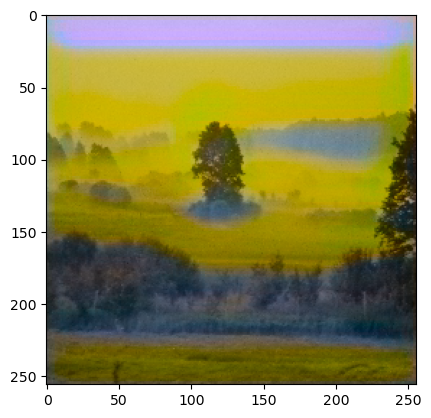

In [72]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
plt.imshow(color_img)
plt.show()

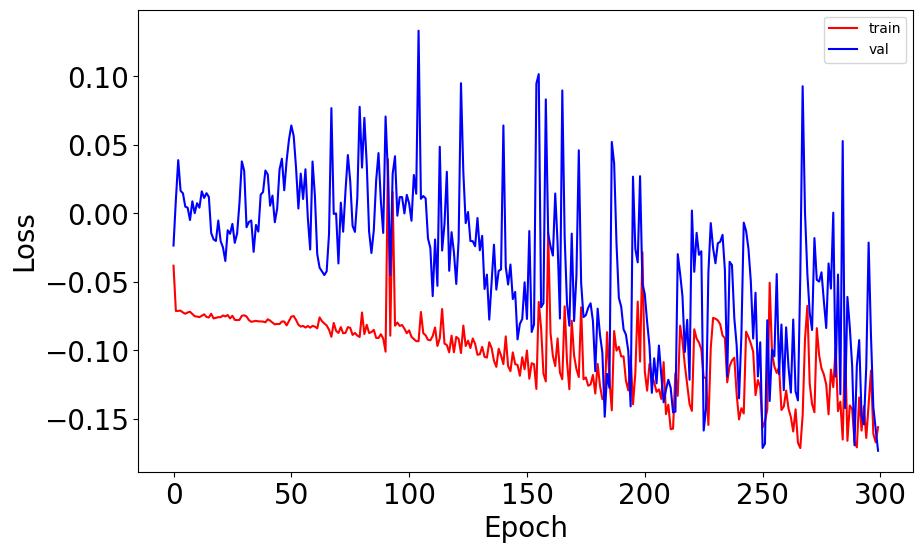

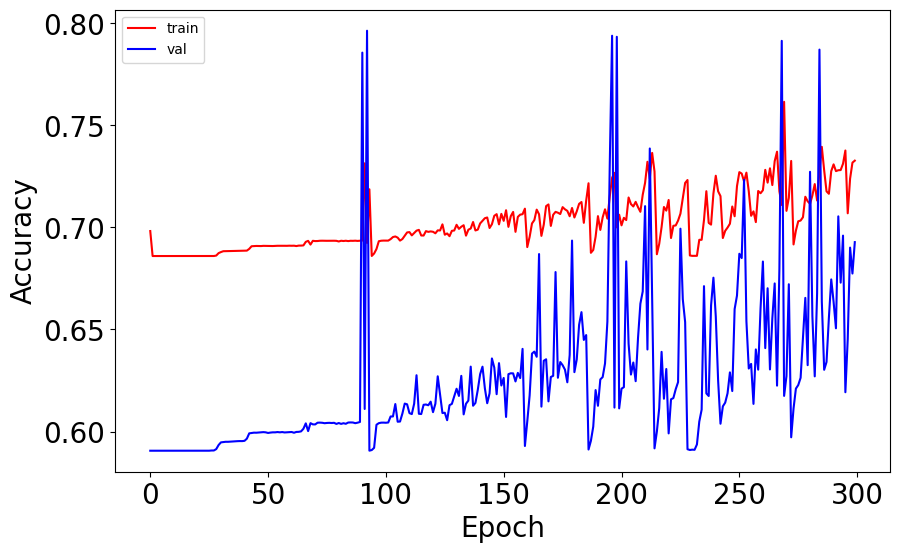

In [73]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history.history['loss'], 'r', label='train')
ax.plot(history.history['val_loss'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [74]:
train_dir = "images/"

#Resize images
img_width = 256
img_height = 256
image_size = (img_width, img_height)

train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True)
        
train = train_datagen.flow_from_directory(batch_size=128,
                                                     directory=train_dir,
                                                     target_size=image_size,
                                                     class_mode=None)

#Convert from RGB to LAB
X = []
y = []
for img in train[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0])
        y.append(lab[:,:,1:] / 128)
    except:
        print('error')
        
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y

Found 10000 images belonging to 1 classes.


In [75]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='tanh', padding='same', strides=2, input_shape=(img_width, img_height, 1)))
model.add(Conv2D(16, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(16, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))
model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))

#Decoder
model.add(Conv2D(32, (3,3), activation='tanh', padding='same'))
model.add(Conv2D(16, (3,3), activation='tanh', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='sgd', loss=tf.keras.losses.CosineSimilarity(axis=1), metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

checkpoint = ModelCheckpoint("model4-tanh-sgd-cs.h5", save_best_only=True)
early_stop = EarlyStopping(patience=50)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(x=X,y=y,validation_split=0.2, epochs=300, batch_size=32, verbose=0, callbacks=[tensorboard_callback, checkpoint, early_stop])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_261 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 conv2d_262 (Conv2D)         (None, 128, 128, 16)      2320      
                                                                 
 conv2d_263 (Conv2D)         (None, 128, 128, 16)      2320      
                                                                 
 conv2d_264 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 conv2d_265 (Conv2D)         (None, 128, 128, 32)      9248      
                                                                 
 conv2d_266 (Conv2D)         (None, 128, 128, 32)      9248      
                                                                 
 conv2d_267 (Conv2D)         (None, 128, 128, 64)    

4/4 [==============================] - 1s 167ms/step
0.7881143093109131


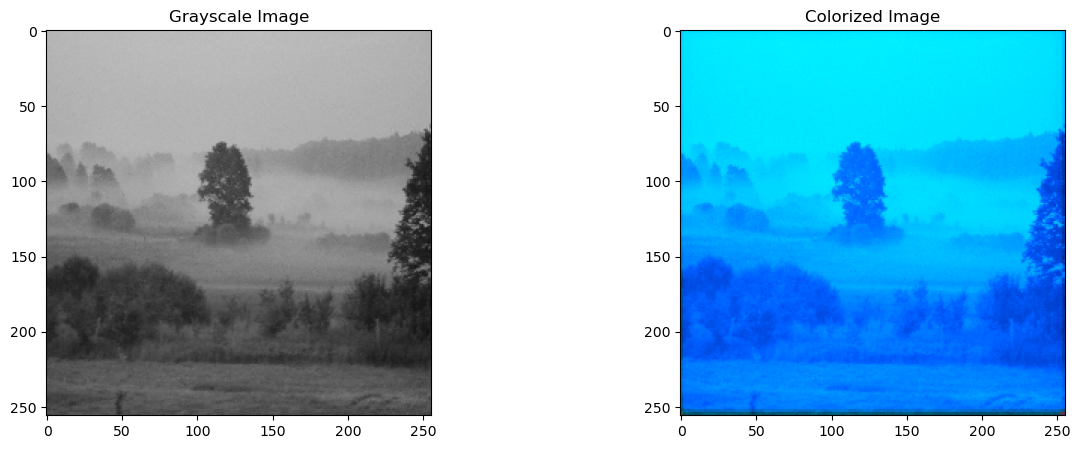

In [76]:
#Convert to LAB
test_img = []
for img in test[0]:
    try:
        lab = rgb2lab(img)
        test_img.append(lab[:,:,0])
    except:
        print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

t = time.time()
output1 = model.predict(test_img)
output1 = output1*128
print(time.time()-t)

grayscale = np.zeros((img_width, img_height, 3))
grayscale[:,:,0] = test_img[16][:,:,0]
grayscale = resize(grayscale, (img_width, img_height))
gray_img = lab2rgb(grayscale)
    
result = np.zeros((img_width, img_height, 3))
result[:,:,0] = test_img[16][:,:,0]
result[:,:,1:] = output1[16]
result = resize(result, (img_width, img_height))
color_img = lab2rgb(result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gray_img)
ax[0].set_title('Grayscale Image')
ax[1].imshow(color_img, cmap='gray')
ax[1].set_title('Colorized Image')
plt.show()

In [77]:
%tensorboard --logdir logs/fit